# Make plots

In [1]:
%load_ext autoreload
%autoreload 2

# Import required modules

In [2]:
import numpy as np, os, sys, glob, tools

import getdist, cobaya
from getdist import plots, MCSamples

import warnings, logging
warnings.filterwarnings("ignore")
logging.getLogger().setLevel(logging.ERROR)

from pylab import *
import tools

In [6]:
rcParams['figure.dpi'] = 150
rcParams['font.family'] = 'serif'
rcParams['figure.facecolor'] = 'white'
#plot(); show()

In [7]:
def make_ver_shades(ax, yarr, colorval = 'gray', alphaval = 0.05, zorder = -10):
    axhline(0., lw = 0.5, alpha = 0.2)
    delta_y = np.diff(yarr)[0]
    for ycntr, yval in enumerate( yarr ):
        if ycntr%2 == 0:
            y1 = yarr[ycntr] - delta_y/2.
            y2 = yarr[ycntr] + delta_y/2.
            axvspan(y1, y2, color = colorval, alpha = alphaval, zorder = zorder)
    return ax

def format_axis(ax, fx, fy, maxxloc=None, maxyloc = None):
    """
    function to format axis fontsize.


    Parameters
    ----------
    ax: subplot axis.
    fx: fontsize for xaxis.
    fy: fontsize for yaxis.
    maxxloc: total x ticks.
    maxyloc: total y ticks.

    Returns
    -------
    formatted axis "ax".
    """
    for label in ax.get_xticklabels(): label.set_fontsize(fx)
    for label in ax.get_yticklabels(): label.set_fontsize(fy)
    if maxyloc is not None:
        ax.yaxis.set_major_locator(MaxNLocator(nbins=maxxloc))
    if maxxloc is not None:
        ax.xaxis.set_major_locator(MaxNLocator(nbins=maxxloc))
        
    ax.tick_params(which = 'major', direction='in', length=3, width=1.)
    ax.tick_params(which = 'minor', direction='in', length=1., width=1.)

    return ax


def add_subplot_axes(ax,rect,axisbg='w'):
    fig = plt.gcf()
    box = ax.get_position()
    width = box.width
    height = box.height
    inax_position  = ax.transAxes.transform(rect[0:2])
    transFigure = fig.transFigure.inverted()
    infig_position = transFigure.transform(inax_position)    
    x = infig_position[0]
    y = infig_position[1]
    width *= rect[2]
    height *= rect[3]  # <= Typo was here
    subax = fig.add_axes([x,y,width,height])#,axisbg=axisbg)
    x_labelsize = subax.get_xticklabels()[0].get_size()
    y_labelsize = subax.get_yticklabels()[0].get_size()
    x_labelsize *= rect[2]**0.5
    y_labelsize *= rect[3]**0.5
    #subax.xaxis.set_tick_params(labelsize=x_labelsize)
    #subax.yaxis.set_tick_params(labelsize=y_labelsize)
    return subax


# Cov checks

(9, 9) (9, 9) (9, 9) (9, 9) (9, 9) (9, 9)


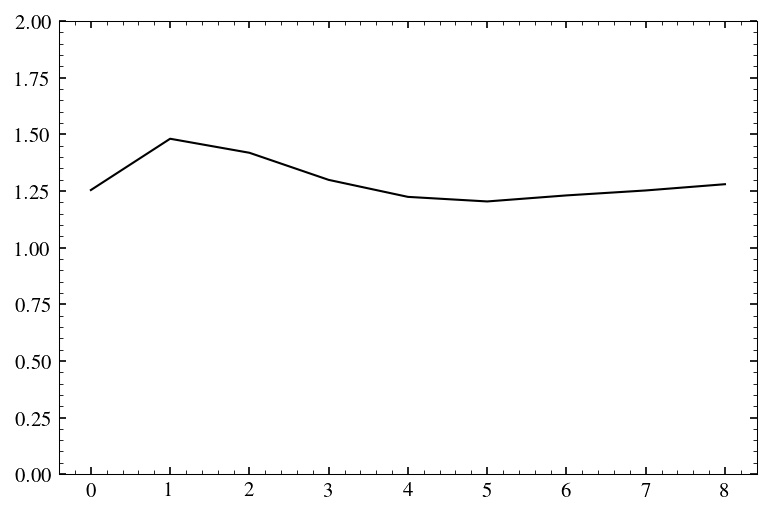

In [8]:
fname = 'results/power_spectra_lmin500_lmax5000_deltal500/100d_tsz_final_estimate_beamrc5.1_noslope.npy'
res_dic = np.load(fname, allow_pickle=True).item()
##print(res_dic.keys()); sys.exit()
op_ps_1d_dic = res_dic['op_ps_1d_dic']
full_stat_cov = res_dic['full_stat_cov']
full_sys_cov_dic = res_dic['full_sys_cov_dic']
m1m2_arr = [('ymv', 'ymv'), ('ycibfree', 'ycibfree'), ('ycibfree', 'ymv')]
tmpels = res_dic[m1m2_arr[0]]['els']
linds = np.arange(len(tmpels))

final_full_sys_cov = full_sys_cov_dic['cib_tweaked_spt_only_max_tweak_0.2'] + \
                full_sys_cov_dic['rad_tweaked_max_tweak_0.2'] + \
                full_sys_cov_dic['cmb_withspiretcalerror'] + \
                full_sys_cov_dic['ksz']
            
full_cov = full_stat_cov + final_full_sys_cov


ilc_keyname1, ilc_keyname2, ilc_keyname3 = ('ymv', 'ymv'), ('ycibfree', 'ycibfree'), ('ycibfree', 'ymv')
tmpels = tmpels[linds]
curr_dl_fac = tmpels * (tmpels+1)/2/np.pi * 1e12
d1_undesired_comp = res_dic[ilc_keyname1]['sim'][linds]
d2_undesired_comp = res_dic[ilc_keyname2]['sim'][linds]
d3_undesired_comp = res_dic[ilc_keyname3]['sim'][linds]
d1 = res_dic[ilc_keyname1]['data_final'][linds]
d2 = res_dic[ilc_keyname2]['data_final'][linds]
d3 = res_dic[ilc_keyname3]['data_final'][linds]
reclen = len(d1)
curr_cov_11 = full_cov[:reclen, :reclen]
curr_cov_22 = full_cov[reclen:2*reclen, reclen:2*reclen]
curr_cov_33 = full_cov[2*reclen:, 2*reclen:]
curr_cov_12 = full_cov[reclen:2*reclen,:reclen]
curr_cov_13 = full_cov[2*reclen:,:reclen]
curr_cov_23 = full_cov[2*reclen:,reclen:2*reclen]
print(curr_cov_11.shape, curr_cov_22.shape, curr_cov_33.shape, curr_cov_12.shape, curr_cov_13.shape, curr_cov_23.shape)

if (1):
    curr_diff_cov = curr_cov_11 + curr_cov_22 - 2 * curr_cov_12
    which_sim = 'cl_arr_for_non_gau_cov'
    m1, m2 = ('ymv', 'ymv'), ('ycibfree', 'ycibfree')
    cl_aa_arr = tools.get_sim_arrary(res_dic, ilc_keyname1, which_sim)
    cl_bb_arr = tools.get_sim_arrary(res_dic, ilc_keyname2, which_sim)
    cl_ab_arr = tools.get_sim_arrary(res_dic, ilc_keyname3, which_sim)
    curr_diff_cov_v2 = tools.get_modified_cov(cl_aa_arr, cl_bb_arr, operation = 'subtract')
    
    #imshow(curr_diff_cov/curr_diff_cov_v2, vmin = 0., vmax = 10.); colorbar(); show()
    #imshow(curr_diff_cov_v2); colorbar(); show()    
    
    plot(np.diag(curr_diff_cov)/np.diag(curr_diff_cov_v2))
    ylim(0., 2)
    show()
    


# SNR calculations

(9, 9) (9, 9) (9, 9) (9, 9) (9, 9) (9, 9)
('ymv', 'ymv')
10.000497996100373 10.00016674208436
('ycibfree', 'ycibfree')
10.252248644371432 10.253462454445145
('ycibfree', 'ymv')
9.635426130972114 9.634658640088672





tmpiter = 0
0.2500000000000011 500 3000
-0.12499999999999922 3000 5000

tmpiter = 1
1.0000000000000018 500 3000
1.0000000000000018 3000 5000

tmpiter = 2
0.32500000000000107 500 3000
0.15000000000000102 3000 5000


<Figure size 900x600 with 0 Axes>

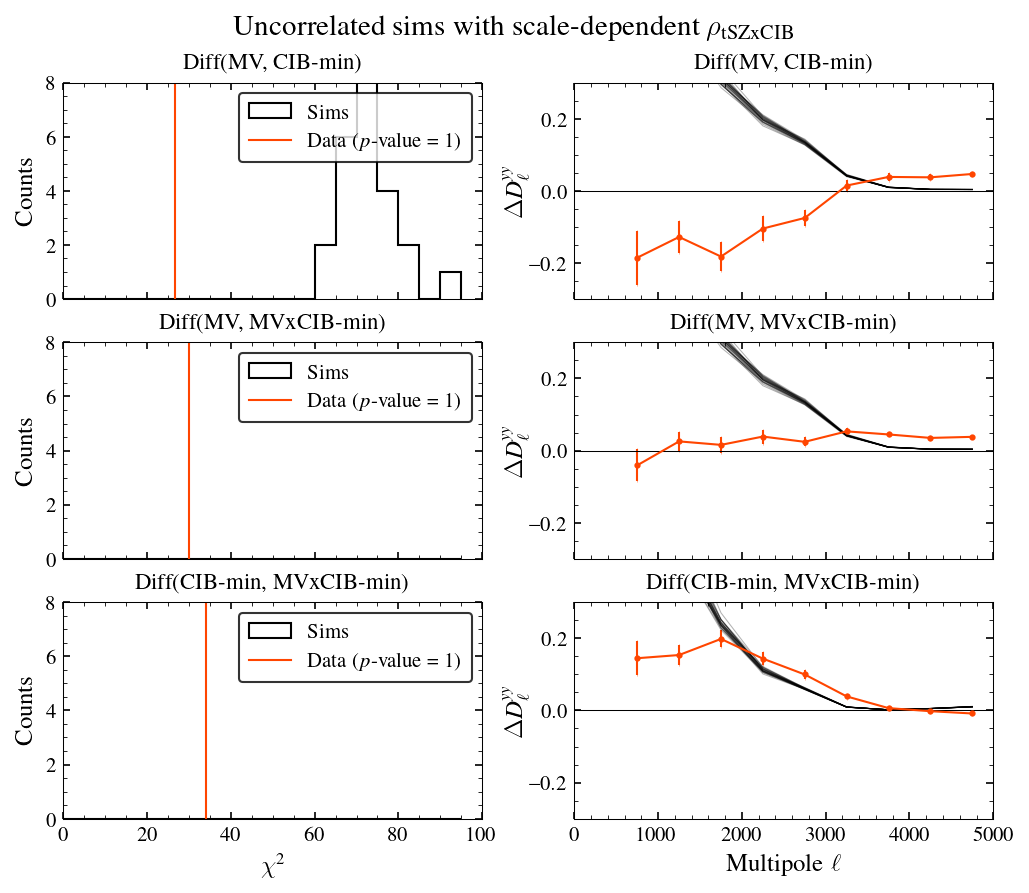

SystemExit: 

In [30]:
from scipy.stats import chi2
#fname = 'results/power_spectra_lmin500_lmax7000_deltal250/100d_tsz_final_estimate.npy'
#fname = 'results/power_spectra_lmin500_lmax7000_deltal250/100d_tsz_final_estimate_beamrc5.1_noslope.npy'
fname = 'results/power_spectra_lmin500_lmax5000_deltal500/100d_tsz_final_estimate_beamrc5.1_noslope.npy'
res_dic = np.load(fname, allow_pickle=True).item()
##print(res_dic.keys()); sys.exit()
op_ps_1d_dic = res_dic['op_ps_1d_dic']
full_stat_cov = res_dic['full_stat_cov']
full_sys_cov_dic = res_dic['full_sys_cov_dic']
m1m2_arr = [('ymv', 'ymv'), ('ycibfree', 'ycibfree'), ('ycibfree', 'ymv')]
tmpels = res_dic[m1m2_arr[0]]['els']

final_full_sys_cov = full_sys_cov_dic['cib_tweaked_spt_only_max_tweak_0.2'] + \
                full_sys_cov_dic['rad_tweaked_max_tweak_0.2'] + \
                full_sys_cov_dic['cmb_withspiretcalerror'] + \
                full_sys_cov_dic['ksz']
            
full_cov = full_stat_cov + final_full_sys_cov

#sim tszxCIB estimates
sim_tsz_cib_estimate_fname = 'results/power_spectra_lmin500_lmax5000_deltal500/100d_tsz_final_estimate_beamrc5.1_noslope_sim_tszcib_estimates.npy'
sim_tsz_cib_estimate_dic = np.load( sim_tsz_cib_estimate_fname, allow_pickle=True).item()
#print(sim_tsz_cib_estimate_dic.keys()); sys.exit()

total_sims_for_tsz_cib = 50
sim_ps_dic = sim_tsz_cib_estimate_dic['sim_ps_dic']
bands = sim_tsz_cib_estimate_dic['bands']
ilc_1d_weights_dic = sim_tsz_cib_estimate_dic['ilc_1d_weights_dic']
#cl_yy_fromcibmindata = sim_tsz_cib_estimate_dic['cl_yy_fromcibmindata']
tmpiter_key = 'cibmindata_tsz' #'sim_tsz'
#tmpiter_key = 'sim_tsz' #'sim_tsz'

wl_dic = {}
for ilc_keyname in ['ymv', 'ycibfree']:
    wl_arr = []
    els = ilc_1d_weights_dic[ilc_keyname]['els']
    for freq in ilc_1d_weights_dic[ilc_keyname]:
        if freq == 'els': continue
        ###print(freq)
        binned_weights = ilc_1d_weights_dic[ilc_keyname][freq]                
        wl = np.interp( tmpels, els, binned_weights )
        wl_arr.append( wl )
    wl_arr = np.asarray(wl_arr)
    wl_dic[ilc_keyname] = wl_arr


#full_stat_corr = corr_from_cov(full_stat_cov)
##imshow(full_stat_corr); colorbar(); show()
linds = np.arange(len(tmpels))
if (0):
    #print( linds, tmpels[linds] )
    #linds = np.where(tmpels<=5000)[0]
    #linds = np.where(tmpels<4000)[0]
    #linds = np.where(tmpels<3500)[0]
    #linds = np.where(tmpels<4000)[0]
    #linds = np.where( (tmpels>3000) & (tmpels<5000) )[0]
    pass


ilc_keyname1, ilc_keyname2, ilc_keyname3 = ('ymv', 'ymv'), ('ycibfree', 'ycibfree'), ('ycibfree', 'ymv')
tmpels = tmpels[linds]
curr_dl_fac = tmpels * (tmpels+1)/2/np.pi * 1e12
d1_undesired_comp = res_dic[ilc_keyname1]['sim'][linds]
d2_undesired_comp = res_dic[ilc_keyname2]['sim'][linds]
d3_undesired_comp = res_dic[ilc_keyname3]['sim'][linds]
d1 = res_dic[ilc_keyname1]['data_final'][linds]
d2 = res_dic[ilc_keyname2]['data_final'][linds]
d3 = res_dic[ilc_keyname3]['data_final'][linds]
reclen = len(d1)
curr_cov_11 = full_cov[:reclen, :reclen]
curr_cov_22 = full_cov[reclen:2*reclen, reclen:2*reclen]
curr_cov_33 = full_cov[2*reclen:, 2*reclen:]
curr_cov_12 = full_cov[reclen:2*reclen,:reclen]
curr_cov_13 = full_cov[2*reclen:,:reclen]
curr_cov_23 = full_cov[2*reclen:,reclen:2*reclen]
print(curr_cov_11.shape, curr_cov_22.shape, curr_cov_33.shape, curr_cov_12.shape, curr_cov_13.shape, curr_cov_23.shape)

"""
if (0): 
    clf()
    dl_fac = tmpels * (tmpels+1)/2/np.pi * 1e12
    plot(tmpels, dl_fac * d1, 'o', color = 'darkgreen')
    plot(tmpels, dl_fac * d2, 'o', color = 'peru')
    plot(tmpels, dl_fac * d3, 'o', color = 'goldenrod')
    ymin, ymax = -0.1, 1.1
    xmin, xmax = -100., 5100.
    xlim(xmin, xmax); ylim(ymin, ymax)
    show(); 

    clf()
    plot(tmpels, (d1-d2) * dl_fac, 'o', color = 'darkgreen')
    plot(tmpels, (d1-d3) * dl_fac, 'o', color = 'peru')
    plot(tmpels, (d2-d3) * dl_fac, 'o', color = 'goldenrod')
    ymin, ymax = -0.3, 0.3
    xmin, xmax = -100., 5100.
    axhline(0., lw = 0.5)
    xlim(xmin, xmax); ylim(ymin, ymax)
    show(); sys.exit()
"""

if (1):
    which_sim = 'cl_arr_for_non_gau_cov'
    m1, m2 = ('ymv', 'ymv'), ('ycibfree', 'ycibfree')
    cl_arr_arr = tools.get_sim_arrary(res_dic, ilc_keyname1, which_sim)
    cl_bb_arr = tools.get_sim_arrary(res_dic, ilc_keyname2, which_sim)
    cl_ab_arr = tools.get_sim_arrary(res_dic, ilc_keyname3, which_sim)
    


use_full = False #True

for m1m2 in m1m2_arr:
    print(m1m2)
    D = res_dic[m1m2]['data_final'][linds]
    if use_full:
        D = res_dic[m1m2]['for_consistency_tests']['data_full']
    C = res_dic[m1m2]['total_cov'][linds[None,:], linds[:,None]]
    Cinv = np.linalg.inv(C)    
    chi_sq_val = np.dot(D, np.dot(D, Cinv))
    snr = np.sqrt( chi_sq_val )
    #print( snr )
    if (1):
        if m1m2 == ilc_keyname1:
            C_v2 = np.copy( curr_cov_11 )
        elif m1m2 == ilc_keyname2:
            C_v2 = np.copy( curr_cov_22 )
        elif m1m2 == ilc_keyname3:
            C_v2 = np.copy( curr_cov_33 )
        Cinv_v2 = np.linalg.inv(C_v2)
        chi_sq_val_v2 = np.dot(D, np.dot(D, Cinv_v2))
        snr_v2 = np.sqrt( chi_sq_val_v2 )
        print(snr, snr_v2)

print('\n\n\n')
#difference tests


#which_sim = 'cl_arr_for_non_gau_cov'
#which_sim = 'cl_sim_all_signals'
#which_sim = 'cib_cmb_rad_tsz_ksz_noise_rc5.1_noslope_spt3gbeams_compdependent_full'
#which_sim = 'cib_cmb_rad_tsz_ksz_noise_rc5.1_noslope_spt3gbeams_compdependent_half_splits'
#which_sim = 'cmb_tsz_ksz_noise_uncorrcib_uncorrrad_rc5.1_noslope_spt3gbeams_compdependent_full'
which_sim = 'cmb_tsz_ksz_noise_uncorrcib_uncorrrad_rc5.1_noslope_spt3gbeams_compdependent_half_splits'

if use_full:
    #which_sim = 'cib_cmb_rad_tsz_ksz_noise_rc5.1_noslope_spt3gbeams_compdependent_full'
    #which_sim = 'cmb_tsz_ksz_noise_uncorrcib_uncorrrad_rc5.1_noslope_spt3gbeams_compdependent_full'
    pass

clf()
figure(figsize = (8., 6.5))
subplots_adjust(wspace=0.22)
tr, tc = 3, 2
sbpl = 1
for tmpiter in range(3):
    #if tmpiter == 0: continue
    print('\ntmpiter = %s' %(tmpiter))
    if tmpiter == 0: #d1, d2
        #data
        curr_diff_vector = d1-d2
        curr_diff_cov = curr_cov_11 + curr_cov_22 - 2 * curr_cov_12

        #sims
        sa_arr = tools.get_sim_arrary(res_dic, ilc_keyname1, which_sim) - d1_undesired_comp
        sb_arr = tools.get_sim_arrary(res_dic, ilc_keyname2, which_sim) - d2_undesired_comp
        m1, m2 = ('ymv', 'ymv'), ('ycibfree', 'ycibfree')
        
        
        title_val = r'Diff(MV, CIB-min)'
        key_for_sima, key_for_simb = ilc_keyname1, ilc_keyname2
        undesired_comp_for_sima, undesired_comp_for_simb = d1_undesired_comp, d2_undesired_comp
    elif tmpiter == 1: #d1, d3
        curr_diff_vector = d1-d3
        curr_diff_cov = curr_cov_11 + curr_cov_33 - 2 * curr_cov_13

        #sims
        sa_arr = tools.get_sim_arrary(res_dic, ilc_keyname1, which_sim) - d1_undesired_comp
        sb_arr = tools.get_sim_arrary(res_dic, ilc_keyname3, which_sim) - d3_undesired_comp
        title_val = r'Diff(MV, MVxCIB-min)'
        m1, m2 = ('ymv', 'ymv'), ('ycibfree', 'ymv')
        key_for_sima, key_for_simb = ilc_keyname1, ilc_keyname3
        undesired_comp_for_sima, undesired_comp_for_simb = d1_undesired_comp, d3_undesired_comp
        
    elif tmpiter == 2: #d2, d3
        curr_diff_vector = d2-d3
        curr_diff_cov = curr_cov_22 + curr_cov_33 - 2 * curr_cov_23

        #sims
        sa_arr = tools.get_sim_arrary(res_dic, ilc_keyname2, which_sim) - d2_undesired_comp
        sb_arr = tools.get_sim_arrary(res_dic, ilc_keyname3, which_sim) - d3_undesired_comp
        title_val = r'Diff(CIB-min, MVxCIB-min)'
        m1, m2 = ('ycibfree', 'ycibfree'), ('ycibfree', 'ymv')
        key_for_sima, key_for_simb = ilc_keyname2, ilc_keyname3
        undesired_comp_for_sima, undesired_comp_for_simb = d2_undesired_comp, d3_undesired_comp
        
    if (1): #recalculate cov locally
        curr_full_cov = tools.get_covs_for_difference_vectors(tmpels, key_for_sima, key_for_simb, op_ps_1d_dic)
        tmpreclen = int( len(curr_full_cov)/2 )
        curr_cov_aa = curr_full_cov[:tmpreclen, :tmpreclen]
        curr_cov_bb = curr_full_cov[tmpreclen:, tmpreclen:]
        curr_cov_ab = curr_full_cov[tmpreclen:, :tmpreclen]
        curr_diff_cov = curr_cov_aa + curr_cov_bb - 2 * curr_cov_ab

    chi_sq_val, chi_val = tools.get_null_test_chi_sq(curr_diff_vector, curr_diff_cov)
    pvalue = chi2.sf(chi_sq_val,len(curr_diff_vector)-1)
    ##sys.exit()

    tit_str = r'Correlated sims'
    if which_sim == 'cmb_tsz_ksz_noise_uncorrcib_uncorrrad_rc5.1_noslope_spt3gbeams_compdependent_half_splits': #add sim tSZ/CIB here

        """
        reqd_tsz_cib_dic = {(500, 1000): 0.3, 
                            (1000, 1500): 0.3, 
                            (1500, 2000): 0.25, 
                            (2000, 2500): 0.25, 
                            (2500, 3000): 0.2, 
                            (3000, 4000): 0.1, 
                            (4000, 7000): 0.05, 
                           }
        """
        reqd_tsz_cib_dic = {(500, 3000): 0.3, 
                            (3000, 5000): 0.05, 
                           }
        """
        reqd_tsz_cib_dic = {(500, 5000): 0.3, 
                           }
        """
        
        tmp_color_arr = ['navy', 'darkgreen', 'goldenrod', 'orangered', 'darkred']
        #perform fitting
        fit_rho_tsz_cib_arr = np.arange(-1, 1.025, 0.025) #0.025)
        #fit_rho_tsz_cib_arr = [0.,0.1, 0.2, 0.3, 0.4, 0.5]
        #fit_rho_tsz_cib_arr = [0.3, 0.4, 0.5]
        cib_scatter_sigma = None #0.2
        for tmpcntr, l1l2 in enumerate( reqd_tsz_cib_dic ):
            #print(l1l2)
            l1, l2 = l1l2
            curr_rho_tsz_cib_linds = np.where( (tmpels>=l1) & (tmpels<l2) )[0]
            
            loglarr = []
            for fit_rho_tsz_cib in fit_rho_tsz_cib_arr:
                sa_arr = tools.get_sim_arrary(res_dic, key_for_sima, which_sim) - undesired_comp_for_sima
                sb_arr = tools.get_sim_arrary(res_dic, key_for_simb, which_sim) - undesired_comp_for_simb
                
                sa_arr, sb_arr, res_cib_a_arr, res_cib_b_arr = tools.account_for_tsz_cib_in_sims(fit_rho_tsz_cib, sa_arr, sb_arr, 
                                                                   sim_ps_dic, 
                                                                   bands, 
                                                                   wl_dic, 
                                                                   m1, m2,
                                                                   sim_tsz_cib_estimate_dic,
                                                                   total_sims_for_tsz_cib = total_sims_for_tsz_cib, 
                                                                   sim_or_data_tsz = tmpiter_key,
                                                                   reqd_linds = curr_rho_tsz_cib_linds, 
                                                                   cib_scatter_sigma = cib_scatter_sigma,
                                                                  )
                
                curr_diff_vector_sim_arr = sa_arr - sb_arr
                curr_diff_vector_sim_arr = curr_diff_vector_sim_arr[25:]
                
                if (0):
                    close('all')
                    clf()
                    tmpdlfac = tmpels * (tmpels+1)/2/np.pi * 1e12
                    plot(tmpels, tmpdlfac * curr_diff_vector, color = 'orangered', marker = 'o')
                    for cl_ in curr_diff_vector_sim_arr:
                        plot(tmpels, tmpdlfac * cl_, color = 'gray')
                    xlim(0., 5000.); ylim(-0.3, 0.3)
                    show(); sys.exit()

                #fitting
                curr_data = curr_diff_vector[curr_rho_tsz_cib_linds]
                curr_model = np.mean( curr_diff_vector_sim_arr, axis = 0)[curr_rho_tsz_cib_linds]
                curr_cov = curr_diff_cov[curr_rho_tsz_cib_linds[None,:], curr_rho_tsz_cib_linds[:,None]]
                loglval = tools.get_likelihood( curr_data, curr_model, curr_cov)
                loglarr.append( loglval )
                
            recov_rho_tsz_cib_ind = np.argmax(loglarr)
            recov_rho_tsz_cib = fit_rho_tsz_cib_arr[recov_rho_tsz_cib_ind]
            reqd_tsz_cib_dic[l1l2] = recov_rho_tsz_cib
            
            larr = tools.get_likelihood_from_loglikelihood(loglarr)
            ##plot(fit_rho_tsz_cib_arr, larr, color = tmp_color_arr[tmpcntr])
        ##show(); ##sys.exit()
        
        ##print(reqd_tsz_cib_dic); sys.exit()
        tit_str = r'Uncorrelated sims with scale-dependent $\rho_{\rm tSZ x CIB}$'
        ##print(sa_arr[25])
        sa_arr = tools.get_sim_arrary(res_dic, key_for_sima, which_sim) - undesired_comp_for_sima
        sb_arr = tools.get_sim_arrary(res_dic, key_for_simb, which_sim) - undesired_comp_for_simb
        for l1l2 in reqd_tsz_cib_dic:
            reqd_tsz_cib = reqd_tsz_cib_dic[l1l2]
            l1, l2 = l1l2
            curr_rho_tsz_cib_linds = np.where( (tmpels>=l1) & (tmpels<l2) )[0]
            print(reqd_tsz_cib, l1, l2)#, curr_rho_tsz_cib_linds)
            sa_arr, sb_arr, res_cib_a_arr, res_cib_b_arr = tools.account_for_tsz_cib_in_sims(reqd_tsz_cib, sa_arr, sb_arr, 
                                                               sim_ps_dic, 
                                                               bands, 
                                                               wl_dic, 
                                                               m1, m2,
                                                               sim_tsz_cib_estimate_dic,
                                                               total_sims_for_tsz_cib = total_sims_for_tsz_cib, 
                                                               sim_or_data_tsz = tmpiter_key,
                                                               reqd_linds = curr_rho_tsz_cib_linds, 
                                                               cib_scatter_sigma = cib_scatter_sigma,
                                                              )
            
    #sim chisq
    curr_diff_vector_sim_arr = sa_arr - sb_arr
    curr_diff_vector_sim_arr = curr_diff_vector_sim_arr[25:]

    if (1): #20251223 - Uncorrelated CIB piece.
        ##print(m1, m2, res_cib_a_arr[0], res_cib_b_arr[0])
        uncorr_cib_in_sa = 0.4 * res_cib_a_arr
        uncorr_cib_in_sb = 0. * res_cib_b_arr

        curr_diff_vector_sim_arr_uncorrcib = uncorr_cib_in_sa - uncorr_cib_in_sb
        curr_diff_vector_sim_arr_uncorrcib = curr_diff_vector_sim_arr_uncorrcib[25:]
        
        ##curr_diff_vector_sim_arr = curr_diff_vector_sim_arr + curr_diff_vector_sim_arr_uncorrcib
        curr_diff_vector_sim_arr = curr_diff_vector_sim_arr_uncorrcib
        ##print(m1, m2, curr_diff_vector_sim_arr[0])

    sim_chi_sq_arr = []
    sim_chi_arr = []
    for cl_ in curr_diff_vector_sim_arr:
        tmp_sim_chi_sq_val, tmp_sim_chi_val = tools.get_null_test_chi_sq(cl_, curr_diff_cov)
        sim_chi_sq_arr.append( tmp_sim_chi_sq_val )
        sim_chi_arr.extend( tmp_sim_chi_val )
    sim_chi_sq_arr = np.asarray( sim_chi_sq_arr )
    
    total_sims = len(sim_chi_sq_arr)
    pvalue_sim_based = float( len(np.where( sim_chi_sq_arr> chi_sq_val )[0]) / total_sims )
    
    if (1):
        ax = subplot(tr, tc, sbpl)
        binbin = np.arange(0, 100, 5)
        hist(sim_chi_sq_arr, bins = binbin, color = 'black', histtype = 'step', label = r'Sims'); 
        axvline(chi_sq_val, color = 'orangered', label = r'Data ($p$-value = %g)' %(pvalue_sim_based))
        xlim(0., 100.); ylim(0, 8)
        if sbpl in [1, 3, 5]:
            legend(loc = 1, fontsize = 10)
        if sbpl >= 5:
            xlabel(r'$\chi^{2}$', fontsize = 12)
        else:
            setp(ax.get_xticklabels(), visible=False)
        if sbpl in [1, 3, 5]:
            ylabel(r'Counts', fontsize = 12)
        title(title_val, fontsize =11)
        sbpl += 1
        
        ax = subplot(tr, tc, sbpl)
        curr_diff_vector_err = np.sqrt( np.diag( curr_diff_cov ) )
        errorbar( tmpels, curr_dl_fac * curr_diff_vector, yerr = curr_dl_fac * curr_diff_vector_err, color = 'orangered', marker = 'o', ms = 2., capsize = 0.1)
        #print(len(curr_diff_vector_sim_arr))
        #color_arr = [cm.RdYlBu_r(int(d)) for d in np.linspace(0, 255, len(curr_diff_vector_sim_arr))][10]
        color_arr1 = [cm.Set1(d) for d in np.arange(0, 10, 1)]
        color_arr2 = [cm.tab20b(d) for d in np.arange(0, 20, 1)]        
        color_arr = np.concatenate((color_arr1, color_arr2))
        color_arr = ['black' for d in np.linspace(0, 255, len(curr_diff_vector_sim_arr))]
        for simcntr, cl_ in enumerate( curr_diff_vector_sim_arr ):
            plot( tmpels, curr_dl_fac * cl_, color = color_arr[simcntr], lw = 0.5, alpha = 0.3)
        xlim(0., 5000.); ylim(-0.3, 0.3)
        if sbpl >= 5:
            xlabel(r'Multipole $\ell$', fontsize = 12)
        else:
            setp(ax.get_xticklabels(), visible=False)
        if sbpl in [2, 4, 6]:
            ylabel(r'$\Delta D_{\ell}^{yy}$', fontsize = 12, labelpad = 0.)
        axhline(0., lw = 0.5); ##show(); #sys.exit()
        title(title_val, fontsize =11)
        sbpl += 1
    
    #print(tmpiter, chi_sq_val, pvalue, pvalue_sim_based); ##sys.exit()
suptitle(tit_str, fontsize = 14, y = 0.95)
show()
sys.exit()



In [ ]:
tmpels

In [15]:
sim_tsz_cib_estimate_dic.keys()

dict_keys(['sim_tsz', 'cibmindata_tsz', 'sim_ps_dic', 'tsz_compton_y_fac', 'tsz_eff_freq_3g_units', 'ilc_1d_weights_dic', 'bands', 'cl_yy_fromcibmindata'])

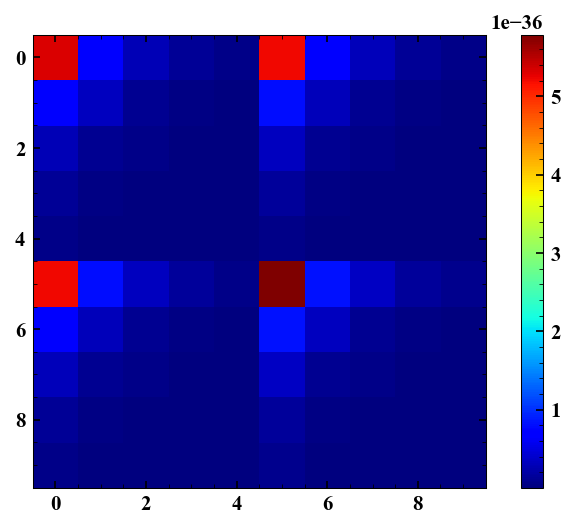

In [87]:
lmin_lmax_arr = [(500, 3000)]
curr_full_cov = tools.get_covs_for_difference_vectors(tmpels, m1, m2, op_ps_1d_dic, lmin_lmax_arr = lmin_lmax_arr)
imshow(curr_full_cov); colorbar(); show()


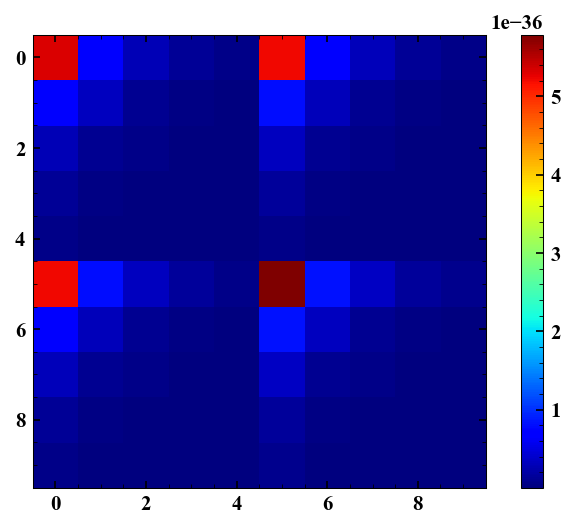

In [88]:
lmin_lmax_arr = [(500, 1500), (1500, 3000)]
curr_full_cov = tools.get_covs_for_difference_vectors(tmpels, m1, m2, op_ps_1d_dic, lmin_lmax_arr = lmin_lmax_arr)
imshow(curr_full_cov); colorbar(); show()


In [18]:

def get_data_vectors(lmin_lmax_arr):
    data = []
    for bincntr, l1l2 in enumerate( lmin_lmax_arr ):
        l1, l2 = l1l2
        curr_rho_tsz_cib_linds = np.where( (tmpels>=l1) & (tmpels<l2) )[0]

        #fitting
        curr_data = curr_diff_vector[curr_rho_tsz_cib_linds]
        data.extend( curr_data )

    return np.asarray( data )

def get_model_vectors(lmin_lmax_arr, param_dict_sampler, sim_or_data_tsz = 'cibmindata_tsz'):
    model = []
    for bincntr, l1l2 in enumerate( lmin_lmax_arr ):
        ##print(l1l2)
        l1, l2 = l1l2
        if param_dict_sampler is not None:
            ppp_name = 'rho_tsz_cib_%s' %(bincntr+1)
            curr_rho_tsz_cib = param_dict_sampler[ppp_name]
        else:
            curr_rho_tsz_cib = None

        curr_rho_tsz_cib_linds = np.where( (tmpels>=l1) & (tmpels<l2) )[0]
        
        sa_arr = tools.get_sim_arrary(res_dic, key_for_sima, which_sim) - undesired_comp_for_sima
        sb_arr = tools.get_sim_arrary(res_dic, key_for_simb, which_sim) - undesired_comp_for_simb
        
        sa_arr, sb_arr = tools.account_for_tsz_cib_in_sims(curr_rho_tsz_cib, sa_arr, sb_arr, 
                                                           sim_ps_dic, 
                                                           bands, 
                                                           wl_dic, 
                                                           key_for_sima, key_for_simb,
                                                           sim_tsz_cib_estimate_dic,
                                                           total_sims_for_tsz_cib = total_sims_for_tsz_cib, 
                                                           sim_or_data_tsz = sim_or_data_tsz,
                                                           reqd_linds = curr_rho_tsz_cib_linds, 
                                                          )

        curr_diff_vector_sim_arr = sa_arr - sb_arr
        curr_diff_vector_sim_arr = curr_diff_vector_sim_arr[25:]

        #fitting
        curr_model = np.mean( curr_diff_vector_sim_arr, axis = 0)[curr_rho_tsz_cib_linds]
        model.extend( curr_model )
            
    return np.asarray( model )


def get_tsz_cib_corr_likelihood(**param_values):
    import copy
    param_values = [param_values[p] for p in param_names]
    param_dict_sampler = {}
    for pcntr, ppp in enumerate( param_names ):
        param_dict_sampler[ppp] = param_values[pcntr]
    
    model = get_model_vectors(lmin_lmax_arr, param_dict_sampler)
    ##print(data.shape, model.shape, curr_diff_cov.shape); sys.exit()
    

    res = tools.get_likelihood(data, model, curr_diff_cov)
    return res



In [9]:
#lmin_lmax_arr = [(500, 3000)]
#lmin_lmax_arr = [(500, 1500), (1500, 3000)]
lmin_lmax_arr = [(500, 1000), (1000, 1500), (1500, 2000), (2000, 2500), (2500, 3000)]
#-----------------------------------
import cobaya

curr_full_cov = tools.get_covs_for_difference_vectors(tmpels, m1, m2, op_ps_1d_dic, lmin_lmax_arr = lmin_lmax_arr)
##print(curr_full_cov.shape); sys.exit()
tmpreclen = int( len(curr_full_cov)/2 )
c_aa = curr_full_cov[:tmpreclen, :tmpreclen]
c_bb = curr_full_cov[tmpreclen:, tmpreclen:]
c_ab = curr_full_cov[tmpreclen:, :tmpreclen]
curr_diff_cov = c_aa + c_bb - 2*c_ab
##imshow(curr_diff_cov); colorbar(); show(); sys.exit()
##print(curr_diff_cov.shape); sys.exit()

total_bins = len( lmin_lmax_arr )
data = get_data_vectors(lmin_lmax_arr)

rho_tsz_cib_ref_dict = {
                "prior": {"min": -1., "max": 1.},
                "ref": {"dist": "norm", "loc": 0.2, "scale": 0.2},
                "proposal": 0.2,
                "drop": False, 
                "latex": r"\rho_{\rm tSZxCIB_binval}", 
                }

mcmc_input_params_info_dict = {}
for binno in range(total_bins):
    paramname = 'rho_tsz_cib_%s' %(binno+1)
    mcmc_input_params_info_dict[paramname] = {}
    for keyname in rho_tsz_cib_ref_dict:
        mcmc_input_params_info_dict[paramname][keyname] = rho_tsz_cib_ref_dict[keyname]
        if keyname == 'latex':
            currval = mcmc_input_params_info_dict[paramname][keyname]
            mcmc_input_params_info_dict[paramname][keyname] = currval.replace('binval', '%s' %(binno+1))


debug_cobaya = False #True ##False ##True
force_resampling = True
GRstat = 0.01
chain_name = 'tsz_cib_corr_samples_%sbins' %(total_bins)
chain_fd_and_name = 'results/chains/%s/%s' %(chain_name, chain_name)

input_info = {}
input_info["params"] = mcmc_input_params_info_dict


param_names = list(input_info["params"].keys())
#print( param_names ); ###sys.exit()

input_info["likelihood"] = {}
input_info["likelihood"]["tsz_cib_fitting"] = {
                "external": get_tsz_cib_corr_likelihood, 
                "input_params": param_names,
                }

input_info["sampler"] = {"mcmc": {"drag": False, "Rminus1_stop": GRstat, "max_tries": 5000}}

input_info["output"] = chain_fd_and_name
updated_info, sampler = cobaya.run(input_info, force = force_resampling, debug = debug_cobaya)
print('Done.')

SystemExit: 

tszcibcorr_cibfree-mvcrosscibfree_totalbins6_lbins-500to1000-1000to1500-1500to2000-2000to2500-2500to3000-3000to5000 (7104, 8)


<Figure size 900x600 with 0 Axes>

<Figure size 900x675 with 0 Axes>

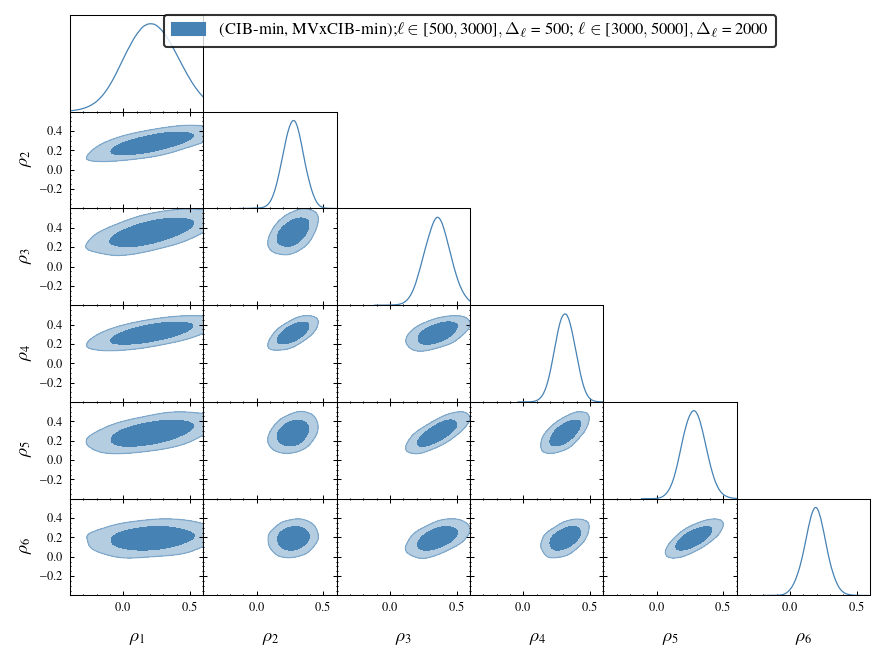

In [27]:
burn_in_fraction = 0.2
rcParams['text.usetex'] = True #False
#rcParams['font.family'] = 'sans-serif'
#rcParams['font.serif'] = ['Computer Modern Roman']

#chain_name = 'tszcibcorr_mv-mvcrosscibfree_totalbins9_lbins-500to1000-1000to1500-1500to2000-2000to2500-2500to3000-3000to3500-3500to4000-4000to4500-4500to5000'
#chain_name = 'tszcibcorr_mv-mvcrosscibfree_totalbins6_lbins-500to1000-1000to1500-1500to2000-2000to2500-2500to3000-3000to5000'

#chain_name = 'tszcibcorr_mv-cibfree_totalbins9_lbins-500to1000-1000to1500-1500to2000-2000to2500-2500to3000-3000to3500-3500to4000-4000to4500-4500to5000'
#chain_name = 'tszcibcorr_mv-cibfree_totalbins6_lbins-500to1000-1000to1500-1500to2000-2000to2500-2500to3000-3000to5000'

#chain_name = 'tszcibcorr_cibfree-mvcrosscibfree_totalbins9_lbins-500to1000-1000to1500-1500to2000-2000to2500-2500to3000-3000to3500-3500to4000-4000to4500-4500to5000'
chain_name = 'tszcibcorr_cibfree-mvcrosscibfree_totalbins6_lbins-500to1000-1000to1500-1500to2000-2000to2500-2500to3000-3000to5000'

chain_name_arr = [
                  ##'tszcibcorr_mv-mvcrosscibfree_totalbins6_lbins-500to1000-1000to1500-1500to2000-2000to2500-2500to3000-3000to5000',
                  'tszcibcorr_cibfree-mvcrosscibfree_totalbins6_lbins-500to1000-1000to1500-1500to2000-2000to2500-2500to3000-3000to5000',
                  ##'tszcibcorr_mv-cibfree_totalbins6_lbins-500to1000-1000to1500-1500to2000-2000to2500-2500to3000-3000to5000',
                 ]

"""
chain_name_arr = [
                  #'tszcibcorr_mv-cibfree_totalbins9_lbins-500to1000-1000to1500-1500to2000-2000to2500-2500to3000-3000to3500-3500to4000-4000to4500-4500to5000',
                  'tszcibcorr_mv-cibfree_totalbins6_lbins-500to1000-1000to1500-1500to2000-2000to2500-2500to3000-3000to5000',
                 ]
"""
"""
chain_name_arr = [
                  'tszcibcorr_cibfree-mvcrosscibfree_totalbins9_lbins-500to1000-1000to1500-1500to2000-2000to2500-2500to3000-3000to3500-3500to4000-4000to4500-4500to5000',
                  'tszcibcorr_cibfree-mvcrosscibfree_totalbins6_lbins-500to1000-1000to1500-1500to2000-2000to2500-2500to3000-3000to5000',
                 ]
"""
samples_arr_to_plot = []
params_arr_to_plot = []
param_limits_dic = {}
label_arr = []
param_values_dict = {}
cib_scatter_sigma = None
tmpiter_key = 'cibmindata_tsz' #'sim_tsz'
#tmpiter_key = 'sim_tsz'
fit_for_cib_cal = 0

for chain_name in chain_name_arr:
    total_bins = int( chain_name.split('_')[2].replace('totalbins', '') )
    #chain_fd_and_name = 'results/chains/%s/%s' %(chain_name, chain_name)
    if fit_for_cib_cal:
        chain_fd_and_name = 'results/chains/%s/fit_for_cib_cal/%s/%s' %(tmpiter_key, chain_name, chain_name)
    else:
        chain_fd_and_name = 'results/chains/%s/cib_scatter_sigma_%s/%s/%s' %(tmpiter_key, cib_scatter_sigma, chain_name, chain_name)
    curr_samples = getdist.mcsamples.loadMCSamples( chain_fd_and_name )
    curr_samples.removeBurn( burn_in_fraction )
    
    chain_labval = chain_name.replace('tszcibcorr_', '')
    chain_labval = chain_labval.replace('mv-cibfree', '(MV, CIB-min);')
    chain_labval = chain_labval.replace('mv-mvcrosscibfree', '(MV, MVxCIB-min);')
    chain_labval = chain_labval.replace('cibfree-mvcrosscibfree', '(CIB-min, MVxCIB-min);')
    chain_labval = chain_labval.replace('_totalbins%s_lbins-' %(total_bins), '')
    chain_labval = chain_labval.replace('500to1000-1000to1500-1500to2000-2000to2500-2500to3000-3000to3500-3500to4000-4000to4500-4500to5000', 
                                       '$\ell \in [500, 5000], \Delta_{\ell} = 500$')
    chain_labval = chain_labval.replace('500to1000-1000to1500-1500to2000-2000to2500-2500to3000-3000to5000', 
                                       '$\ell \in [500, 3000], \Delta_{\ell} = 500$; $\ell \in [3000, 5000], \Delta_{\ell} = 2000$' )
    chain_labval = r'%s' %(chain_labval)
    label_arr.append( chain_labval )
    
    #change param str
    param_values_dict[chain_name] = {}
    for ppp in curr_samples.paramNames.list():
        if ppp.find('chi')>-1: continue
        currstrval = curr_samples.paramNames.parWithName(ppp).label
        mod_currstrval = currstrval.replace('\\rho_{\\rm tSZxCIB_', '\\rho_{')
        curr_samples.paramNames.parWithName(ppp).label = mod_currstrval
        param_limits_dic[ppp] = [-0.4, 0.6]
        param_values_dict[chain_name][ppp] = curr_samples.getLatex(ppp)
        #print(param_values_dict[chain_labval][ppp]); sys.exit()

    params_to_plot = []
    for binno in range( total_bins ):
        params_to_plot.append( 'rho_tsz_cib_%s' %(binno+1) )
    ##print(params_to_plot); sys.exit()

    '''
    for ppp in params_to_plot:
        g = plots.get_single_plotter(width_inch = 3)
        g.plot_1d( curr_samples, ppp)
        show()
    '''
    print(chain_name, curr_samples.samples.shape)
    samples_arr_to_plot.append( curr_samples )
    params_arr_to_plot.extend( params_to_plot )
    
params_arr_to_plot = np.unique( params_arr_to_plot )
##print( params_arr_to_plot ); sys.exit()

close('all')
clf()
g = plots.get_single_plotter(width_inch = 6)
g.settings.title_limit_fontsize = 20
if len(params_arr_to_plot) == 6:
    g.settings.legend_fontsize = 13
elif len(params_arr_to_plot) == 6:
    g.settings.legend_fontsize = 17
else:
    g.settings.legend_fontsize = 13
g.triangle_plot(samples_arr_to_plot, params=params_arr_to_plot, 
                contour_colors=['steelblue', 'sienna', 'black'],
                #contour_colors=['silver', 'tab:green', 'peru', 'black'],
                #contour_colors=['peru'],
                framealpha = 1., 
                filled=[True, True, True],
                param_limits = param_limits_dic, 
                legend_labels = label_arr,
                )
total_subplots = len( g.subplots )
for r in range( total_subplots ):
    for c in range( total_subplots ):
        if c>r:continue
        ax = g.subplots[r,c]
        ax.tick_params('both', length=2, width=0.5, which='major', direction = 'in')
        ax.tick_params('both', length=0.5, width=0.5, which='minor', direction = 'in')
        if r == c: ax.yaxis.set_visible(False) #diagonal
            
plname = 'rho_tsz_cib.png'
savefig(plname, dpi = 200.)
show()        

In [147]:
param_values_dict

{'tszcibcorr_mv-cibfree_totalbins6_lbins-500to1000-1000to1500-1500to2000-2000to2500-2500to3000-3000to5000': {'rho_tsz_cib_1': '\\rho_{1} = 0.43\\pm 0.24',
  'rho_tsz_cib_2': '\\rho_{2} = 0.26\\pm 0.11',
  'rho_tsz_cib_3': '\\rho_{3} = 0.35\\pm 0.12',
  'rho_tsz_cib_4': '\\rho_{4} = 0.21\\pm 0.11',
  'rho_tsz_cib_5': '\\rho_{5} = 0.224\\pm 0.099',
  'rho_tsz_cib_6': '\\rho_{6} = -0.112\\pm 0.093'}}

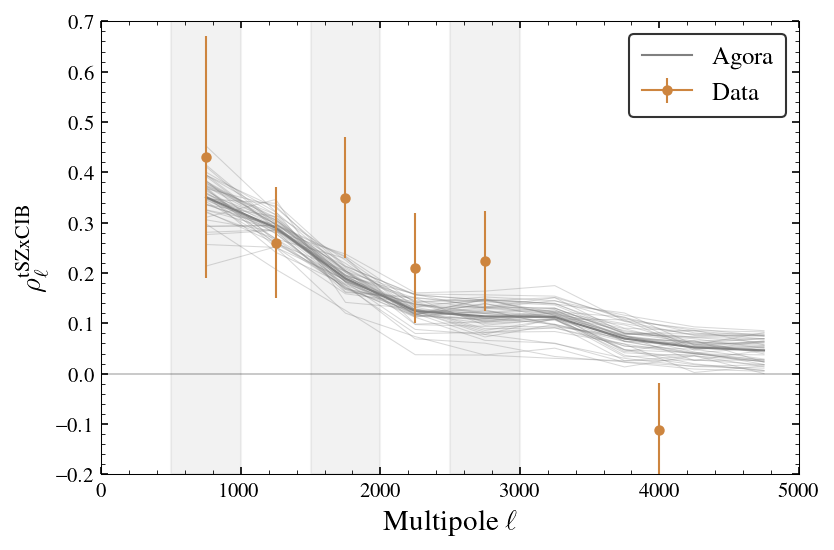

In [148]:
def get_agora_rho_tsz_cib(band1 = 150, band2 = 150, total_sims = 50):
    agora_rho_tsz_cib_arr = []
    for tmpsimno in range(total_sims):
        cl_tsz = sim_ps_dic[tmpsimno][(band1, band2)]['tsz']
        cl_cib = sim_ps_dic[tmpsimno][(band1, band2)]['cib']
        cl_tsz_cib = sim_ps_dic[tmpsimno][(band1, band2)]['tsz_cib']
        agora_rho_tsz_cib = abs( cl_tsz_cib / np.sqrt( cl_tsz * cl_cib) )
        agora_rho_tsz_cib_arr.append( agora_rho_tsz_cib )

    agora_rho_tsz_cib_arr = np.asarray( agora_rho_tsz_cib_arr )
    return agora_rho_tsz_cib_arr                  

clf()
agora_color = 'gray'
fsval = 14
agora_rho_tsz_cib_arr = get_agora_rho_tsz_cib(band1 = 90, band2 = 90)
agora_rho_tsz_cib_mean = np.mean(agora_rho_tsz_cib_arr, axis = 0)
# print(agora_rho_tsz_cib_mean)
# agora_rho_tsz_cib_arr = get_agora_rho_tsz_cib()
# agora_rho_tsz_cib_mean = np.mean(agora_rho_tsz_cib_arr, axis = 0)
# print(agora_rho_tsz_cib_mean)
# sys.exit()
for agora_rho_tsz_cib in agora_rho_tsz_cib_arr:
    plot(tmpels, agora_rho_tsz_cib, color = agora_color, alpha = 0.3, lw = 0.5, zorder = -10)
plot(tmpels, agora_rho_tsz_cib_mean, color = agora_color, lw = 1., label = r'Agora')

#reqd_chain_name = 'tszcibcorr_mv-cibfree_totalbins6_lbins-500to1000-1000to1500-1500to2000-2000to2500-2500to3000-3000to5000'
#reqd_chain_name = 'tszcibcorr_mv-cibfree_totalbins6_lbins-500to1000-1000to1500-1500to2000-2000to2500-2500to3000-3000to5000'
#reqd_chain_name = 'tszcibcorr_cibfree-mvcrosscibfree_totalbins9_lbins-500to1000-1000to1500-1500to2000-2000to2500-2500to3000-3000to3500-3500to4000-4000to4500-4500to5000'
reqd_chain_name_arr = np.asarray( list(param_values_dict.keys()) )#[1:]
#color_arr = ['green', 'darkorange']
color_arr = ['peru']
#reqd_chain_name_arr = [reqd_chain_name]
for tmpcntr, reqd_chain_name in enumerate( reqd_chain_name_arr ):
    ell_bin_str_split = reqd_chain_name.split('lbins-')[1].split('-')
    for pppcntr, ppp in enumerate( param_values_dict[reqd_chain_name] ):
        l1l2 = np.asarray( ell_bin_str_split[pppcntr].split('to') ).astype(float)
        l1, l2 = l1l2
        lcen = np.mean(l1l2)
        lerr = (l1l2[1] - l1l2[0])/2
        if pppcntr%2 == 0:
            axvspan(lcen-lerr, lcen+lerr, color = 'gray', alpha = 0.1)
        ppp_val_str = param_values_dict[reqd_chain_name][ppp].split('=')[1]
        ppp_val, ppp_err_val = np.asarray( ppp_val_str.split('\pm') ).astype(float)
        ##print(ppp_val, ppp_err_val); sys.exit()
        if pppcntr == 0:
            labval = r'Data'
        else:
            labval = None
        errorbar(lcen, ppp_val, 
                 #xerr = lerr, 
                 yerr = ppp_err_val, 
                 color = color_arr[tmpcntr],  
                 capsize = 0.,
                marker = 'o', ms = 4.,
                label = labval,
                )
ylim(-0.2, 0.7)
xlim(0., 5000.)
axhline(0., lw= 0.2); axhline(1., lw= 0.2)
xlabel(r'Multipole $\ell$', fontsize = fsval)
ylabel(r'$\rho_{\ell}^{\rm tSZ x CIB}$', fontsize = fsval)
legend(loc = 1, fontsize = 12)
show()



In [ ]:
burn_in_fraction = 0.2
rcParams['text.usetex'] = True #False
rcParams['font.family'] = 'sans-serif'
rcParams['font.serif'] = ['Computer Modern Roman']
chain_name_arr = ['tsz_cib_corr_samples_1bins', 'tsz_cib_corr_samples_2bins', 'tsz_cib_corr_samples_5bins']
for chain_name in chain_name_arr:
    chain_fd_and_name = 'results/chains/%s/%s' %(chain_name, chain_name)
    curr_samples = getdist.mcsamples.loadMCSamples( chain_fd_and_name )
    curr_samples.removeBurn( burn_in_fraction )



    
    if chain_name == 'tsz_cib_corr_samples_1bins': 
        g = plots.get_single_plotter(width_inch = 3)
        g.plot_1d( curr_samples, 'rho_tsz_cib_1')
        show()
    else:
        
        total_bins = int( chain_name.split('_')[-1].replace('bins', '') )
        params_to_plot = []
        for binno in range( total_bins ):
            params_to_plot.append( 'rho_tsz_cib_%s' %(binno+1) )
        
        '''
        for ppp in params_to_plot:
            g = plots.get_single_plotter(width_inch = 3)
            g.plot_1d( curr_samples, ppp)
            show()
        '''


        clf()
        g = plots.get_single_plotter(width_inch = 5)
        g.triangle_plot(curr_samples, params=params_to_plot, 
                        contour_colors=['tab:green'], 
                        framealpha = 1., 
                        filled=True,
                        )
        
        show()        
        

In [27]:
tmp = get_sim_tsz_cib(lmin_lmax_arr, key_for_sima, key_for_simb, undesired_comp_for_sima, undesired_comp_for_simb)
print(tmp)
    
    

[-1.34081437e-18 -4.68890689e-19 -2.62063485e-19 -1.37253534e-19
 -7.36678435e-20]


In [ ]:
final_full_sys_cov = full_sys_cov_dic['cib_tweaked_spt_only_max_tweak_0.2'] + \
                full_sys_cov_dic['rad_tweaked_max_tweak_0.2'] + \
                full_sys_cov_dic['cmb_withspiretcalerror'] + \
                full_sys_cov_dic['ksz']


In [214]:
curr_diff_cov_v2 = tools.get_covs_for_difference_vectors(tmpels, m2, m3, op_ps_1d_dic, lmin_lmax_arr = [[500, 1500], [1500, 3000]])


[[5.62099670e-36 7.58433187e-37 5.39373430e-36 7.60260435e-37
  3.22939302e-37 1.38752060e-37 6.66292939e-38 3.12872394e-37
  1.36650200e-37 6.11971302e-38]
 [7.58433187e-37 3.02669104e-37 7.23076888e-37 2.97814704e-37
  9.88147698e-38 3.87703055e-38 2.07682902e-38 9.66147389e-38
  3.87925109e-38 2.02382105e-38]
 [5.39373430e-36 7.23076888e-37 5.32285226e-36 7.30878009e-37
  3.07955199e-37 1.30186299e-37 6.14631974e-38 2.99684026e-37
  1.29294185e-37 5.60088395e-38]
 [7.60260435e-37 2.97814704e-37 7.30878009e-37 2.99377833e-37
  9.80705716e-38 3.91264055e-38 2.08883871e-38 9.65239073e-38
  3.92848124e-38 2.03433172e-38]
 [3.22939302e-37 9.88147698e-38 3.07955199e-37 9.80705716e-38
  6.17301179e-38 2.04375609e-38 1.11956326e-38 5.89203824e-38
  2.02989627e-38 1.08867235e-38]
 [1.38752060e-37 3.87703055e-38 1.30186299e-37 3.91264055e-38
  2.04375609e-38 1.32643079e-38 4.92045914e-39 1.93764399e-38
  1.29921924e-38 4.86808268e-39]
 [6.66292939e-38 2.07682902e-38 6.14631974e-38 2.08883871e

SystemExit: 

In [213]:
m1, m2, m3 = m1m2_arr
curr_diff_cov_v2 = tools.get_covs_for_difference_vectors(tmpels, m2, m3, op_ps_1d_dic, lmin_lmax_arr = [[500, 3000]])


[[5.62099670e-36 7.58433187e-37 3.22939302e-37 1.38752060e-37
  6.66292939e-38 5.39373430e-36 7.60260435e-37 3.12872394e-37
  1.36650200e-37 6.11971302e-38]
 [7.58433187e-37 3.02669104e-37 9.88147698e-38 3.87703055e-38
  2.07682902e-38 7.23076888e-37 2.97814704e-37 9.66147389e-38
  3.87925109e-38 2.02382105e-38]
 [3.22939302e-37 9.88147698e-38 6.17301179e-38 2.04375609e-38
  1.11956326e-38 3.07955199e-37 9.80705716e-38 5.89203824e-38
  2.02989627e-38 1.08867235e-38]
 [1.38752060e-37 3.87703055e-38 2.04375609e-38 1.32643079e-38
  4.92045914e-39 1.30186299e-37 3.91264055e-38 1.93764399e-38
  1.29921924e-38 4.86808268e-39]
 [6.66292939e-38 2.07682902e-38 1.11956326e-38 4.92045914e-39
  4.39608227e-39 6.14631974e-38 2.08883871e-38 1.05601323e-38
  5.07190645e-39 4.30666213e-39]
 [5.39373430e-36 7.23076888e-37 3.07955199e-37 1.30186299e-37
  6.14631974e-38 5.32285226e-36 7.30878009e-37 2.99684026e-37
  1.29294185e-37 5.60088395e-38]
 [7.60260435e-37 2.97814704e-37 9.80705716e-38 3.91264055e

SystemExit: 

In [219]:
m1, m2, m3 = m1m2_arr
#curr_diff_cov_v2 = tools.get_covs_for_difference_vectors(tmpels, m1, m2, op_ps_1d_dic)#, lmin = 500, lmax = 5001)
curr_diff_cov_v2 = tools.get_covs_for_difference_vectors(tmpels, m2, m3, op_ps_1d_dic, lmin_lmax_arr = [[500, 5001]])
#curr_diff_cov_v2 = tools.get_covs_for_difference_vectors(tmpels, m2, m3, op_ps_1d_dic, lmin_lmax_arr = [[500, 1500], [1500, 5001]])
tmpreclen = int( len(curr_diff_cov_v2)/2 )
curr_cov_11_v2 = curr_diff_cov_v2[:tmpreclen, :tmpreclen]
curr_cov_22_v2 = curr_diff_cov_v2[tmpreclen:, tmpreclen:]
curr_cov_12_v2 = curr_diff_cov_v2[tmpreclen:, :tmpreclen]
curr_cov_21_v2 = curr_diff_cov_v2[:tmpreclen, tmpreclen:].T
#imshow(curr_diff_cov_v2); colorbar(); show()

print( curr_cov_22/curr_cov_11_v2 )
print( curr_cov_33/curr_cov_22_v2 )
print( curr_cov_23/curr_cov_12_v2 )
#print( curr_cov_21_v2 )


[[1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]]
[[1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]]
[[1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]]


In [139]:
sim_tsz_cib_estimate_dic['cibmindata_tsz'][('ymv', 'ymv')][0.25].keys()

dict_keys([25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41])

In [118]:
res_dic[m1].keys()

dict_keys(['els', 'data', 'sim', 'data_final', 'data_final_cluster_masked_dic', 'data_error', 'sims_dic', 'cl_for_sub_arr', 'cl_sim_all_signals', 'cl_arr_sim_tsz', 'sim_all_signals_keyname', 'sim_tsz_only', 'cl_sim_all_signals_full', 'sim_all_signals_full_keyname', 'noise', 'for_consistency_tests', 'cl_sys_dic', 'stat_cov', 'cl_arr_for_gau_cov', 'stat_cov_non_gau', 'cl_arr_for_non_gau_cov', 'total_cov', 'cov_sys_dic'])

In [70]:
res_dic[ilc_keyname1]['for_consistency_tests'].keys()

dict_keys(['cmb_tsz_ksz_noise_uncorrcib_uncorrrad_rc5.1_noslope_spt3gbeams_compdependent_half_splits', 'data_full'])

In [ ]:
if (0):
    print('\n\nEfstathiou and McCarthy now')

    #SNR of Efstathiou and McCarthy
    tmpfname = 'data/Efstathiou_2025.txt'
    tmpels, tmpdlyy, tmpdlyy_err = np.loadtxt( tmpfname, unpack = True )

    linds = np.arange(len(tmpels))
    #linds = np.where(tmpels<2000)[0]
    #linds = np.where(tmpels>2000)[0]

    tmpels, tmpdlyy, tmpdlyy_err = tmpels[linds], tmpdlyy[linds], tmpdlyy_err[linds]

    tmpcov = np.eye( len(tmpdlyy) ) * tmpdlyy_err**2
    #print(tmpcov)

    tmpcov_inv = np.linalg.inv(tmpcov)
    tmpchi_sq_val = np.dot(tmpdlyy, np.dot(tmpdlyy, tmpcov_inv))
    tmpsnr = np.sqrt( tmpchi_sq_val )
    print( tmpsnr )


In [81]:
res_dic[ilc_keyname1]['sim_all_signals_keyname']

'cmb_tsz_ksz_noise_uncorrcib_uncorrrad_rc5.1_noslope_spt3gbeams_compdependent'